In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
from torch import nn


2026-01-07 16:56:09.097328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load your CSV
df = pd.read_csv("/home/elsherif/Desktop/Thesis/ViewPython/data/Train Data/rooftop.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14059 entries, 0 to 14058
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         14059 non-null  object 
 1   total_rooftops               14059 non-null  int64  
 2   rooftops_without_solar       14059 non-null  int64  
 3   square_meters_with_solar_m2  14059 non-null  float64
 4   panel_area_m2                14059 non-null  float64
 5   district_number              14059 non-null  int64  
 6   year                         14059 non-null  int64  
 7   Unemployment_Rate            14059 non-null  object 
 8   Average_Age                  14059 non-null  object 
 9   Elderly_Population           14059 non-null  float64
 10  Young_Population             14059 non-null  float64
 11  Total_Population             14059 non-null  int64  
 12  Number_of_Houses             7796 non-null   float64
dtypes: float64(5), i

In [3]:
# List of numeric columns that may have commas
numeric_cols = ["Unemployment_Rate", "Average_Age"]

# Replace commas and convert to float
for col in numeric_cols:
    df[col] = df[col].str.replace(",", ".").astype(float)

In [4]:
tiles_with_2020 = df[df["year"] == 2020]["tile"].unique()
all_tiles = df["tile"].unique()
tiles_missing_2020 = [t for t in all_tiles if t not in tiles_with_2020]

print("Tiles missing 2020:", tiles_missing_2020)


Tiles missing 2020: ['tile_r54_c10', 'tile_r54_c22']


In [5]:
df_clean = df[~df["tile"].isin(tiles_missing_2020)].copy()


In [6]:
df = df.drop(columns=["Number_of_Houses"])


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14059 entries, 0 to 14058
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         14059 non-null  object 
 1   total_rooftops               14059 non-null  int64  
 2   rooftops_without_solar       14059 non-null  int64  
 3   square_meters_with_solar_m2  14059 non-null  float64
 4   panel_area_m2                14059 non-null  float64
 5   district_number              14059 non-null  int64  
 6   year                         14059 non-null  int64  
 7   Unemployment_Rate            14059 non-null  float64
 8   Average_Age                  14059 non-null  float64
 9   Elderly_Population           14059 non-null  float64
 10  Young_Population             14059 non-null  float64
 11  Total_Population             14059 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 1.3+ MB


In [8]:
df

,tile,total_rooftops,rooftops_without_solar,square_meters_with_solar_m2,panel_area_m2,district_number,year,Unemployment_Rate,Average_Age,Elderly_Population,Young_Population,Total_Population
0,tile_r0_c0,7,5,529.887,101.361,20,2012,3.8,42.9,10627.0,7361.0,47949
1,tile_r0_c1,9,9,0.000,0.000,20,2012,3.8,42.9,10627.0,7361.0,47949
2,tile_r0_c10,90,80,3339.949,201.642,21,2012,3.2,42.2,13608.0,11579.0,69295
3,tile_r0_c11,97,90,2715.933,343.005,21,2012,3.2,42.2,13608.0,11579.0,69295
4,tile_r0_c12,42,39,5222.084,75.094,21,2012,3.2,42.2,13608.0,11579.0,69295
...,...,...,...,...,...,...,...,...,...,...,...,...
14054,tile_r9_c5,133,128,1730.995,57.297,20,2006,5.7,42.6,9505.0,7243.0,44993
14055,tile_r9_c6,107,101,2633.512,86.413,20,2006,5.7,42.6,9505.0,7243.0,44993
14056,tile_r9_c7,83,77,2363.406,133.379,25,2006,5.5,43.4,10182.0,6152.0,50028
14057,tile_r9_c8,58,53,3174.716,53.238,25,2006,5.5,43.4,10182.0,6152.0,50028


In [9]:
df = df.set_index(['tile','year'])

In [10]:
# 1️⃣ Reset index so 'tile' and 'year' are columns
df_reset = df.reset_index()  # or df.reset_index(drop=False)

# 2️⃣ List all tiles and all years
tiles = df_reset['tile'].unique()
all_years = np.arange(2003, 2025)

# 3️⃣ Create a full MultiIndex of all (tile, year) combinations
import itertools
full_index = pd.MultiIndex.from_tuples(list(itertools.product(tiles, all_years)), names=['tile','year'])

# 4️⃣ Set MultiIndex and reindex
df_full = df_reset.set_index(['tile','year']).reindex(full_index)

# 5️⃣ Interpolate numeric columns
numeric_cols = [
    "total_rooftops",
    "rooftops_without_solar",
    "square_meters_with_solar_m2",
    "Unemployment_Rate",
    "Average_Age",
    "Elderly_Population",
    "Young_Population",
    "Total_Population",
    "panel_area_m2"
]
df_full[numeric_cols] = df_full[numeric_cols].interpolate(method='linear')

# 6️⃣ Forward/backward fill any remaining NaNs
df_full[numeric_cols] = df_full[numeric_cols].fillna(method='ffill').fillna(method='bfill')


/tmp/ipykernel_9226/1255893820.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full[numeric_cols] = df_full[numeric_cols].fillna(method='ffill').fillna(method='bfill')


In [11]:
df = df_full

In [12]:
df = df_full.reset_index()

In [13]:
df["panel_area_log"] = np.log1p(df["panel_area_m2"])


In [14]:
df

,tile,year,total_rooftops,rooftops_without_solar,square_meters_with_solar_m2,panel_area_m2,district_number,Unemployment_Rate,Average_Age,Elderly_Population,Young_Population,Total_Population,panel_area_log
0,tile_r0_c0,2003,7.0,6.000000,181.557000,14.890000,20.0,4.600000,42.600000,8329.000000,6922.0,42823.000000,2.765690
1,tile_r0_c0,2004,7.0,6.333333,121.038000,9.926667,NaN,4.966667,42.600000,8721.000000,7029.0,43546.333333,2.391206
2,tile_r0_c0,2005,7.0,6.666667,60.519000,4.963333,NaN,5.333333,42.600000,9113.000000,7136.0,44269.666667,1.785630
3,tile_r0_c0,2006,7.0,7.000000,0.000000,0.000000,20.0,5.700000,42.600000,9505.000000,7243.0,44993.000000,0.000000
4,tile_r0_c0,2007,7.0,6.666667,52.863333,0.390000,NaN,5.333333,42.633333,9765.333333,7242.0,45492.000000,0.329304
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34447,tile_r9_c9,2020,132.0,125.000000,2251.183000,173.403000,21.0,3.800000,42.300000,14631.000000,13257.0,77301.000000,5.161369
34448,tile_r9_c9,2021,128.0,117.500000,3566.847500,237.313500,NaN,3.500000,42.100000,14741.500000,13659.5,78805.000000,5.473587
34449,tile_r9_c9,2022,124.0,110.000000,4882.512000,301.224000,21.0,3.200000,41.900000,14852.000000,14062.0,80309.000000,5.711168
34450,tile_r9_c9,2023,124.0,111.000000,4227.782000,396.798000,NaN,3.450000,41.900000,14947.500000,14127.0,81056.500000,5.985944


In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding, Concatenate, RepeatVector
)
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split


In [16]:
df = df.sort_values(["tile", "year"]).copy()

# Encode tile IDs
le = LabelEncoder()
df["tile_id"] = le.fit_transform(df["tile"])
num_tiles = df["tile_id"].nunique()

feature_cols = [
    "total_rooftops",
    "rooftops_without_solar",
    "square_meters_with_solar_m2",
    "Unemployment_Rate",
    "Average_Age",
    "Elderly_Population",
    "Young_Population",
    "Total_Population"
]

# Scale numeric features
scaler_X = MinMaxScaler()
df[feature_cols] = scaler_X.fit_transform(df[feature_cols])

# Scale target
scaler_y = MinMaxScaler()
df["panel_scaled"] = scaler_y.fit_transform(df[["panel_area_m2"]])


In [17]:
seq_len = 3

def create_sequences(df, seq_len=3):
    X_numeric, X_tile, y = [], [], []

    for _, group in df.groupby("tile_id"):
        group = group.sort_values("year")
        
        num_vals = group[feature_cols].values
        tile_vals = group["tile_id"].values
        target_vals = group["panel_area_log"].values

        for i in range(len(group) - seq_len):
            X_numeric.append(num_vals[i:i+seq_len])
            X_tile.append(tile_vals[i])  # ONE tile id per sequence
            y.append(target_vals[i+seq_len])

    return np.array(X_numeric), np.array(X_tile), np.array(y)

X_numeric, X_tile, y = create_sequences(df, seq_len)
print("X_numeric:", X_numeric.shape)
print("X_tile:", X_tile.shape)
print("y:", y.shape)


X_numeric: (29754, 3, 8)
X_tile: (29754,)
y: (29754,)


In [18]:
# Compute threshold
upper = np.percentile(y, 99.9)

# Boolean mask for sequences to keep
mask = y <= upper

# Apply mask
X_numeric_filtered = X_numeric[mask]
X_tile_filtered    = X_tile[mask]
y_filtered         = y[mask]

print("Before:", len(y))
print("After:", len(y_filtered))


Before: 29754
After: 29724


In [19]:
# Xn_train, Xn_test, Xt_train, Xt_test, y_train, y_test = train_test_split(
#     X_numeric, X_tile, y, test_size=0.1, shuffle=False
# )
# Number of sequences
num_samples = len(X_numeric)
split_idx = int(num_samples * 0.85)  

Xn_train, Xn_test = X_numeric[:split_idx], X_numeric[split_idx:]
Xt_train, Xt_test = X_tile[:split_idx], X_tile[split_idx:]
y_train, y_test   = y[:split_idx], y[split_idx:]


In [20]:
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Embedding, Concatenate,
    RepeatVector, Lambda, Dropout
)
from tensorflow.keras.models import Model
import tensorflow as tf

# --- Model hyperparams ---
num_features = len(feature_cols)
embedding_dim = 4
hidden_size = 128     # bigger for better learning
seq_len = 3          # your choice

# --- Inputs ---
numeric_input = Input(shape=(seq_len, num_features))
tile_input = Input(shape=(1,))

# --- Tile embedding ---
tile_emb = Embedding(num_tiles, embedding_dim)(tile_input)    # (batch,1,emb)
tile_emb = Lambda(lambda x: tf.squeeze(x, axis=1))(tile_emb)  # (batch,emb)
tile_emb = RepeatVector(seq_len)(tile_emb)                    # (batch,seq,emb)

# --- Merge numeric + embedding ---
merged = Concatenate(axis=-1)([numeric_input, tile_emb])       # (batch,seq,feat+emb)

# ------------------------
#   2-layer LSTM encoder
# ------------------------

# First LSTM: learns temporal structure
x = LSTM(
        hidden_size,
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.1
    )(merged)

# Second LSTM: compress sequence into final representation
x = LSTM(
        hidden_size // 2,
        dropout=0.2,
        recurrent_dropout=0.1
    )(x)

# --- Output layer (predict log-panel area) ---
output = Dense(1)(x)

# --- Build model ---
model = Model(inputs=[numeric_input, tile_input], outputs=output)
model.compile(optimizer="adam", loss="mse")

model.summary()


2026-01-07 16:56:31.697899: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 4)      │      6,264 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 4)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 3, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 3, 4)      │          0 │ lambda[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 12)     │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3, 128)    │     72,192 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 127,929 (499.72 KB)

 Trainable params: 127,929 (499.72 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True, monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5, patience=75, monitor="val_loss"
    )
]

history = model.fit(
    [Xn_train, Xt_train],
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 1.8567 - val_loss: 5.3958 - learning_rate: 0.0010
Epoch 2/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.8469 - val_loss: 5.5330 - learning_rate: 0.0010
Epoch 3/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.7710 - val_loss: 5.4405 - learning_rate: 0.0010
Epoch 4/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.7346 - val_loss: 5.3268 - learning_rate: 0.0010
Epoch 5/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - loss: 0.7133 - val_loss: 5.8375 - learning_rate: 0.0010
Epoch 6/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.6931 - val_loss: 5.3427 - learning_rate: 0.0010
Epoch 7/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.6774 - val_loss: 5.8826 - learning_rate: 0.0010
Epoch 8/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.6618 - val_loss: 5.4600 - learning_rate: 0.0010
Epoch 9/300
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - loss: 0.6485 - val_loss

In [22]:
y_pred_log = model.predict([Xn_test, Xt_test])
# y_pred = scaler_y.inverse_transform(y_pred_scaled)
# y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred = np.expm1(y_pred_log)

y_test_real = np.expm1(y_test)

140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


In [23]:
from sklearn.metrics import r2_score, mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
print("Test RMSE:", rmse)
r2 = r2_score(y_test_real, y_pred)

#print("RMSE:", rmse)
print("R2:", r2)


Test RMSE: 1321.6428429483867
R2: 0.09604644792877048


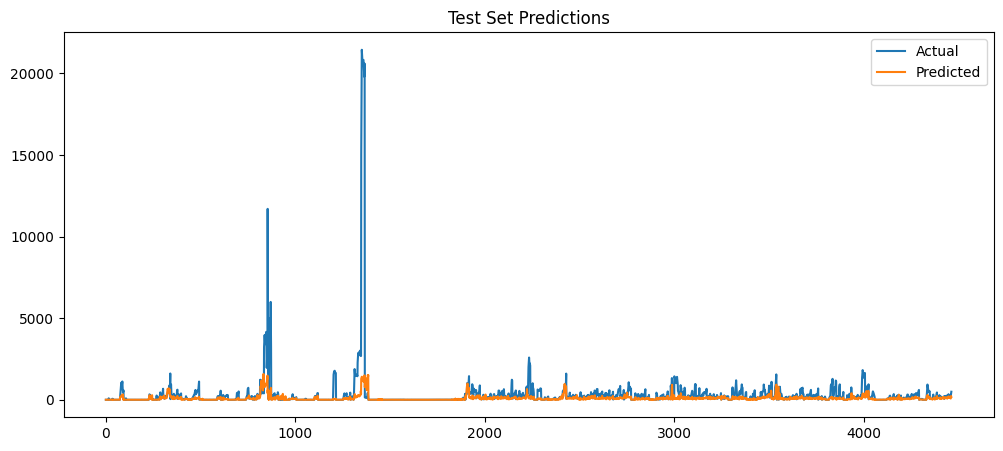

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_real, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Test Set Predictions")
plt.show()


---------------------------------------------------------

In [25]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["tile"] = le.fit_transform(df["tile"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34452 entries, 0 to 34451
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tile                         34452 non-null  int64  
 1   year                         34452 non-null  int64  
 2   total_rooftops               34452 non-null  float64
 3   rooftops_without_solar       34452 non-null  float64
 4   square_meters_with_solar_m2  34452 non-null  float64
 5   panel_area_m2                34452 non-null  float64
 6   district_number              14059 non-null  float64
 7   Unemployment_Rate            34452 non-null  float64
 8   Average_Age                  34452 non-null  float64
 9   Elderly_Population           34452 non-null  float64
 10  Young_Population             34452 non-null  float64
 11  Total_Population             34452 non-null  float64
 12  panel_area_log               34452 non-null  float64
 13  tile_id         

In [26]:
df.head()

,tile,year,total_rooftops,rooftops_without_solar,square_meters_with_solar_m2,panel_area_m2,district_number,Unemployment_Rate,Average_Age,Elderly_Population,Young_Population,Total_Population,panel_area_log,tile_id,panel_scaled
0,0,2003,0.029412,0.025532,0.002356,14.890000,20.0,0.446429,0.796296,0.266339,0.268560,0.240350,2.765690,0,0.000694
1,0,2004,0.029412,0.026950,0.001571,9.926667,NaN,0.511905,0.796296,0.285429,0.274217,0.247399,2.391206,0,0.000463
2,0,2005,0.029412,0.028369,0.000785,4.963333,NaN,0.577381,0.796296,0.304519,0.279875,0.254448,1.785630,0,0.000231
3,0,2006,0.029412,0.029787,0.000000,0.000000,20.0,0.642857,0.796296,0.323610,0.285533,0.261497,0.000000,0,0.000000
4,0,2007,0.029412,0.028369,0.000686,0.390000,NaN,0.577381,0.802469,0.336288,0.285480,0.266359,0.329304,0,0.000018


In [27]:
feature_cols = [
    "total_rooftops",
    "rooftops_without_solar",
    "square_meters_with_solar_m2",
    "Unemployment_Rate",
    "Average_Age",
    "Elderly_Population",
    "Young_Population",
    "Total_Population"
]
from sklearn.preprocessing import MinMaxScaler

# Flatten for scaling
scaler_X = MinMaxScaler()

# Combine all sequences later; for now scale df numeric features
df_scaled = df.copy()
df_scaled[feature_cols] = scaler_X.fit_transform(df_scaled[feature_cols])

# Scale target
scaler_y = MinMaxScaler()
df_scaled["panel_area_m2_scaled"] = scaler_y.fit_transform(df_scaled[["panel_area_m2"]])


In [28]:
df = df_scaled

In [29]:
df["tile"].nunique()

1566

In [30]:
df = df.sort_values(["tile", "year"])
from torch import nn


In [31]:
num_tiles = df["tile"].nunique()  # 1500
embedding_dim = 1 # you can increase if needed

tile_embedding = nn.Embedding(num_tiles, embedding_dim)

In [32]:
feature_cols = [
    "total_rooftops",
    "Unemployment_Rate",
    "Average_Age",
    "Elderly_Population",
    "Young_Population",
    "Total_Population",
]


In [33]:
import numpy as np
import torch

feature_cols = [
    "total_rooftops",
    "Unemployment_Rate",
    "Average_Age",
    "Elderly_Population",
    "Young_Population",
    "Total_Population",
]

seq_len = 3  # number of years in each sequence

def create_sequences(df, seq_len=3):
    X_numeric_list, X_tile_list, y_list = [], [], []

    for _, group in df.groupby("tile"):
        group = group.sort_values("year")
        values = group[feature_cols].values
        tile_ids = group["tile"].values
        target = group["panel_area_m2_scaled"].values

        for i in range(len(group) - seq_len):
            X_numeric_list.append(values[i:i+seq_len])
            X_tile_list.append(tile_ids[i:i+seq_len])
            y_list.append(target[i+seq_len])

    return np.array(X_numeric_list), np.array(X_tile_list), np.array(y_list)

# Create sequences
X_numeric, X_tile_ids, y = create_sequences(df, seq_len=seq_len)
print("X_numeric:", X_numeric.shape, "X_tile_ids:", X_tile_ids.shape, "y:", y.shape)


X_numeric: (29754, 3, 6) X_tile_ids: (29754, 3) y: (29754,)


In [34]:
from sklearn.model_selection import train_test_split

X_num_train, X_num_test, X_tile_train, X_tile_test, y_train, y_test = train_test_split(
    X_numeric, X_tile_ids, y, test_size=0.2, shuffle=False
)

# Convert to PyTorch tensors
X_num_train_t = torch.tensor(X_num_train, dtype=torch.float32)
X_num_test_t = torch.tensor(X_num_test, dtype=torch.float32)
X_tile_train_t = torch.tensor(X_tile_train, dtype=torch.long)
X_tile_test_t = torch.tensor(X_tile_test, dtype=torch.long)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


In [35]:
from torch import nn

num_tiles = df["tile"].nunique()
num_numeric_features = len(feature_cols)
embedding_dim = 2
hidden_size =8
num_layers = 1

class TileLSTM(nn.Module):
    def __init__(self, num_numeric_features, num_tiles, embedding_dim, hidden_size, num_layers=1):
        super().__init__()
        self.tile_embedding = nn.Embedding(num_tiles, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=num_numeric_features + embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x_numeric, x_tile):
        tile_emb = self.tile_embedding(x_tile)             # trainable embeddings
        x = torch.cat([x_numeric, tile_emb], dim=-1)      # combine numeric + tile
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])                       # last timestep
        return out

model = TileLSTM(num_numeric_features, num_tiles, embedding_dim, hidden_size, num_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [36]:
epochs = 50

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    pred = model(X_num_train_t, X_tile_train_t)
    loss = loss_fn(pred, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {loss.item():.6f}")


Epoch 5: Train Loss = 0.029259
Epoch 10: Train Loss = 0.021767
Epoch 15: Train Loss = 0.015572
Epoch 20: Train Loss = 0.010735
Epoch 25: Train Loss = 0.007299
Epoch 30: Train Loss = 0.005163
Epoch 35: Train Loss = 0.004008
Epoch 40: Train Loss = 0.003396
Epoch 45: Train Loss = 0.002984
Epoch 50: Train Loss = 0.002636


Test Loss: 0.005383449140936136


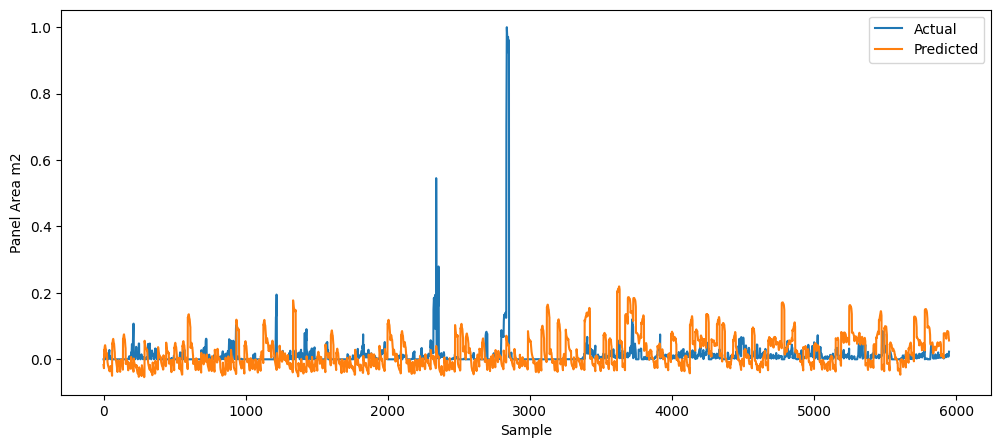

In [37]:
model.eval()
with torch.no_grad():
    test_pred = model(X_num_test_t, X_tile_test_t)
    test_loss = loss_fn(test_pred, y_test_t)

print("Test Loss:", test_loss.item())

# Example plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(y_test, label="Actual")
plt.plot(test_pred.numpy(), label="Predicted")
plt.xlabel("Sample")
plt.ylabel("Panel Area m2")
plt.legend()
plt.show()


In [38]:
y_true = y_test_t.numpy().flatten()
y_pred = test_pred.numpy().flatten()


In [39]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


In [40]:
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"R² score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


R² score: -0.6631
MAE: 0.0411
MSE: 0.0054
RMSE: 0.0734
